# Assignment 2

## Preliminary Steps

Let's import all the needed packages

In [1]:
# Handle files and unzip
import os
import requests
import zipfile

import re

import pandas as pd
import numpy as np

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Word tokenization
from tensorflow.keras.preprocessing.text import Tokenizer


import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
!pip install tqdm
from tqdm import tqdm as tq 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf
from keras.layers import * 
from keras.initializers import Constant
from keras.models import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's download the dataset

In [2]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Look inside our dataset creating a first dataframe reading the `test_pairs.csv` file

In [3]:
train_path = os.path.join(os.getcwd(), 'dataset', 'train_pairs.csv')
val_path = os.path.join(os.getcwd(), 'dataset', 'val_pairs.csv')
test_path = os.path.join(os.getcwd(), 'dataset', 'test_pairs.csv')

## Data preparation

As stated in [specifications.ipynb](specifications.ipynb), each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

So now we construct a new dataframe where each sample is in the form (Claim, Evidence, Lable).

In [4]:
# the evidences seems to be separated by a tab (\t) 
# so it may be used to split the Evidence string

# this dataset is a mess
dataset_path = os.path.join(os.getcwd(), 'dataset', 'train_pairs.csv')

def sentence_cleaning(sentence: str) -> str:
    """
    cleans up a sentence in the dataset using regular expressions
    :param sentence: the sentence to clean-up
    :return
        - string cleaned
    """
    
    # removes "-LRB-" and "-RRB-" strings and commas
    sentence = re.sub("-LRB-","", sentence)
    sentence = re.sub("-RRB-", "", sentence)
    #sentence = re.sub(",", "", sentence)
    sentence = re.sub("-LSB-", "", sentence)
    sentence = re.sub("-RSB-", "", sentence)
    
    return sentence
    

def format_dataset(dataset: str, debug: bool = True) -> pd.DataFrame:
    """
    Reads out the csv file and returns a dataframe with 
    {Claim, Evidence, Label} row
    
    :param dataset: dataset csv file path
    :param debug: if True prints out data for debugging purposes
    
    :return
        - dataframe with (claim, evidence, label) rows
    """
    
    df = pd.read_csv(dataset)
    dataframe_rows = []
    df_size = df.shape[0]

    for i in range(0, df_size):

        claim = df["Claim"][i]
        claim = sentence_cleaning(str(claim))

        label = df["Label"][i]

        ev_list = df["Evidence"][i].split('\t')
        evidence = sentence_cleaning(str(ev_list[1]))
        #evidence = ev_list[1]

        

        # create single dataframe row
        dataframe_row = {
            "Claim": claim,
            "Evidence": evidence,
            "Label": label
        }

        if debug: 
            print(claim)
            print(evidence)
            print(label)

        dataframe_rows.append(dataframe_row)

    df = pd.DataFrame(dataframe_rows)
    
    return df, dataframe_rows

df, df_rows = format_dataset(dataset_path, False)

df['Claim_Evidence'] = df.Claim + df.Evidence
df['Label'] = df.Label

df_train, df_rows_train = format_dataset(train_path, False)
df_val, df_rows_val = format_dataset(val_path, False)
df_test, df_rows_test = format_dataset(test_path, False)


df_tot = pd.concat([df_train, df_val, df_test])
df_tot = df_tot.reset_index()
df_tot['Claim_Evidence'] = df_tot.Claim + df_tot.Evidence

Let's see how the resulting dataframe looks like

In [5]:
df.head()

,Claim,Evidence,Label,Claim_Evidence
0,Chris Hemsworth appeared in A Perfect Getaway.,Hemsworth has also appeared in the science fic...,SUPPORTS,Chris Hemsworth appeared in A Perfect Getaway....
1,Roald Dahl is a writer.,"Roald Dahl langpronˈroʊ.əld _ ˈdɑːl , ˈɾuː...",SUPPORTS,Roald Dahl is a writer.Roald Dahl langpronˈr...
2,Roald Dahl is a governor.,"Roald Dahl langpronˈroʊ.əld _ ˈdɑːl , ˈɾuː...",REFUTES,Roald Dahl is a governor.Roald Dahl langpron...
3,Ireland has relatively low-lying mountains.,The island 's geography comprises relatively l...,SUPPORTS,Ireland has relatively low-lying mountains.The...
4,Ireland does not have relatively low-lying mou...,The island 's geography comprises relatively l...,REFUTES,Ireland does not have relatively low-lying mou...


Turning claims and Evidences into sequences of integers

In [6]:
def make_sequences(texts, lower=True, filters='!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n'):
    """
    Turn a set of texts into sequences of integers
    
    :param texts: the set of texts to turn into sequences
    :param lower: boolean. Whether to convert the texts to lowercase
    :param filters: a string where each element is a character that will be filtered from the texts
    """
    
    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)
    
    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts
    
    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)
    
    return word_idx, idx_word, num_words, word_counts, sequences

def encode_dataframe(dataframe):
    """
    Creates sequences of integers for both Claim and Evidence columns
    """
    
    # creates lists of claims and evidences
    #claims = list(dataframe['Claim'])
    #evidences = list(dataframe['Evidence'])
    claims_evidences = list(dataframe['Claim_Evidence'])
    
    cl_word_idx, cl_idx_word, cl_num_words, cl_word_counts, seq_claim_ev = make_sequences(claims_evidences)
    #ev_word_idx, ev_idx_word, ev_num_words, ev_word_counts, seq_evidences = make_sequences(evidences)

    
    return seq_claim_ev

#seq_claims_evidences = encode_dataframe(df)

In [7]:
lower=True 
filters='!"#$%&()*+-/:;<=>?@[\\]^_.`{|}~\t\n'
# Create the tokenizer object and train on texts
tokenizer = Tokenizer(lower=lower, filters=filters)
tokenizer.fit_on_texts(df_tot[0:len(df_rows_train)].Claim_Evidence)
# Create look-up dictionaries and reverse look-ups
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word
num_words = len(word_idx) + 1
word_counts = tokenizer.word_counts
# Convert text to sequences of integers
token_claim = tokenizer.texts_to_sequences(df_tot.Claim)
token_evidence = tokenizer.texts_to_sequences(df_tot.Evidence)

Constructing the input matrices for the embedding step. We construct the matrices starting from `seq_claims` and `seq_evidences`. The number of rows of the matrices is the number of elements in `seq_claims` and `seq_evidences`, while the number of columns is the size of the longest sequences. The rows corresponding to shorter sequences are filled with zero-padding.

In [8]:
# computes the longest token sequence
def longest_seq(seq):
    seq_len = [len(i) for i in seq]
    
    return max(seq_len)

def matrix_from_sequences(sequences):
    """
    Builds a matrix of shape [batch_size, max_tokens]
    """
    
    max_tokens = longest_seq(sequences)
    seq_length = len(sequences)
    
    matrix = np.zeros((len(sequences), max_tokens), dtype=np.int32)
    
    for i in range(0, seq_length):
        for j in range(0, len(sequences[i])):
            matrix[i][j] = sequences[i][j]
    
    return matrix

claim_matrix = matrix_from_sequences(token_claim)
evidence_matrix = matrix_from_sequences(token_evidence)

print(claim_matrix.shape)
print(evidence_matrix.shape)


(136094, 76)
(136094, 137)


Dataframe split

In [9]:
claim_matrix_train = claim_matrix[0:len(df_rows_train)]
evidence_matrix_train = evidence_matrix[0:len(df_rows_train)]

claim_matrix_val = claim_matrix[len(df_rows_train): len(df_rows_train) +len(df_rows_val)]
evidence_matrix_val = evidence_matrix[len(df_rows_train): len(df_rows_train) +len(df_rows_val)]

claim_matrix_test = claim_matrix[len(df_rows_train) +len(df_rows_val)::]
evidence_matrix_test = evidence_matrix[len(df_rows_train) +len(df_rows_val)::]

data_train = (claim_matrix_train,evidence_matrix_train)
data_val = (claim_matrix_val,evidence_matrix_val)
data_test = (claim_matrix_test,evidence_matrix_test)

WORD EMBEDDING

In [10]:
import random

In [11]:
import urllib
url = "https://nlp.stanford.edu/data/glove.6B.zip"

glove_path = os.path.join(os.getcwd(),"Glove")
glove_zip = os.path.join(os.getcwd(),"Glove", "glove.6B.zip")

if not os.path.exists(glove_path):
    os.makedirs(glove_path)

if not os.path.exists(glove_zip):
    urllib.request.urlretrieve(url, glove_zip)
    print("Successful download")

with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall(path=glove_path)
    print("Successful extraction")


Successful extraction


In [12]:
EMBEDDING_SIZE  = 50  # dimensions of the features of GloVe 
VOCABULARY_SIZE_TRAIN = num_words
embedding_weights = np.zeros((num_words, EMBEDDING_SIZE))

V1 = {}
glove_path = '/content/Glove'
with open(glove_path + '/glove.6B.{}d.txt'.format(EMBEDDING_SIZE),'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        V1[word]=vector
        
print("Found %s word vectors." % len(V1))

def compute_embedding(word2id, vocabulary,embedding_weights):
  for word, index in tq(word2id.items()):
    if word in vocabulary:
      try: 
        embedding_weights[index, :] = V1[word] 
      except KeyError:
          embedding_weights[index, :] = np.random.uniform(random.choice(list(V1.values())))
          pass
  return embedding_weights


embedding_words = compute_embedding(word_idx,list(word_idx.keys()),embedding_weights)



Found 400000 word vectors.


100%|██████████| 37318/37318 [01:29<00:00, 418.26it/s]


### Sentence Embedding

In [13]:
sequence_length_cl = 76
sequence_length_ev = 137
embed_dim = 50 # for glove50.txt
embedding_matrix= embedding_words #np.random.rand(claim_matrix.shape[0],embed_dim)

claim_input = Input(shape=(sequence_length_cl,), name = 'claim_input')
embedding_layer_c = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix], 
                            input_length = sequence_length_cl, trainable=True, 
                            name='claim_embedding')(claim_input)

evidence_input = Input(shape=(sequence_length_ev,), name = 'evidence_input')
embedding_layer_e = Embedding(embedding_matrix.shape[0], embed_dim, weights=[embedding_matrix], 
                            input_length = sequence_length_ev, trainable=True, 
                            name='evidence_embedding')(evidence_input)

#¶¶¶¶¶¶¶¶¶
X_claim = Bidirectional(LSTM(units=int(embed_dim/2), 
                         name='blstm_1', 
                         #dropout=0.25, 
                         #recurrent_dropout=0.25, 
                        return_sequences=True))(embedded_claim) 
                    # If you want to switch merge_mode='concat', for the 1 point
                    # purpose we check it as None
X_claim = Dropout(0.25)(X_claim) 
X_claim = Dense(embed_dim,activation='relu')(X_claim) 
X_claim = Dropout(0.25)(X_claim)


X_evidence = Bidirectional(LSTM(units=int(embed_dim/2), 
                         name='blstm_1',
                         return_sequences=True 
                          ))(embedded_evidence) 
                    # If you want to switch merge_mode='concat', for the 1 point
                    # purpose we check it as None
X_evidence = Dropout(0.25)(X_evidence) 
X_evidence = Dense(embed_dim,activation='relu')(X_evidence) 
X_evidence = Dropout(0.25)(X_evidence)
# ¶¶¶¶¶¶¶¶¶¶¶¶¶¶¶¶
lstm_input = concatenate([X_claim,X_evidence], name='lstm_input',axis=1)
lstm_input = (SpatialDropout1D(0.2))(lstm_input)
lstm_input = (Bidirectional(CuDNNLSTM(64, return_sequences=True)))(lstm_input)
lstm_input = (Bidirectional(CuDNNLSTM(32)))(lstm_input)
lstm_input = (Dropout(0.25))(lstm_input)
lstm_input = (Dense(units=3, activation='sigmoid', use_bias=False))(lstm_input)


In [14]:
model_main = keras.Model([claim_input,evidence_input],lstm_input)
model_main.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model_main.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 137)]        0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 76, 50)       1865950     ['claim_input[0][0]']            
                                                                                                  
 evidence_embedding (Embedding)  (None, 137, 50)     1865950     ['evidence_input[0][0]']         
                                                                                              

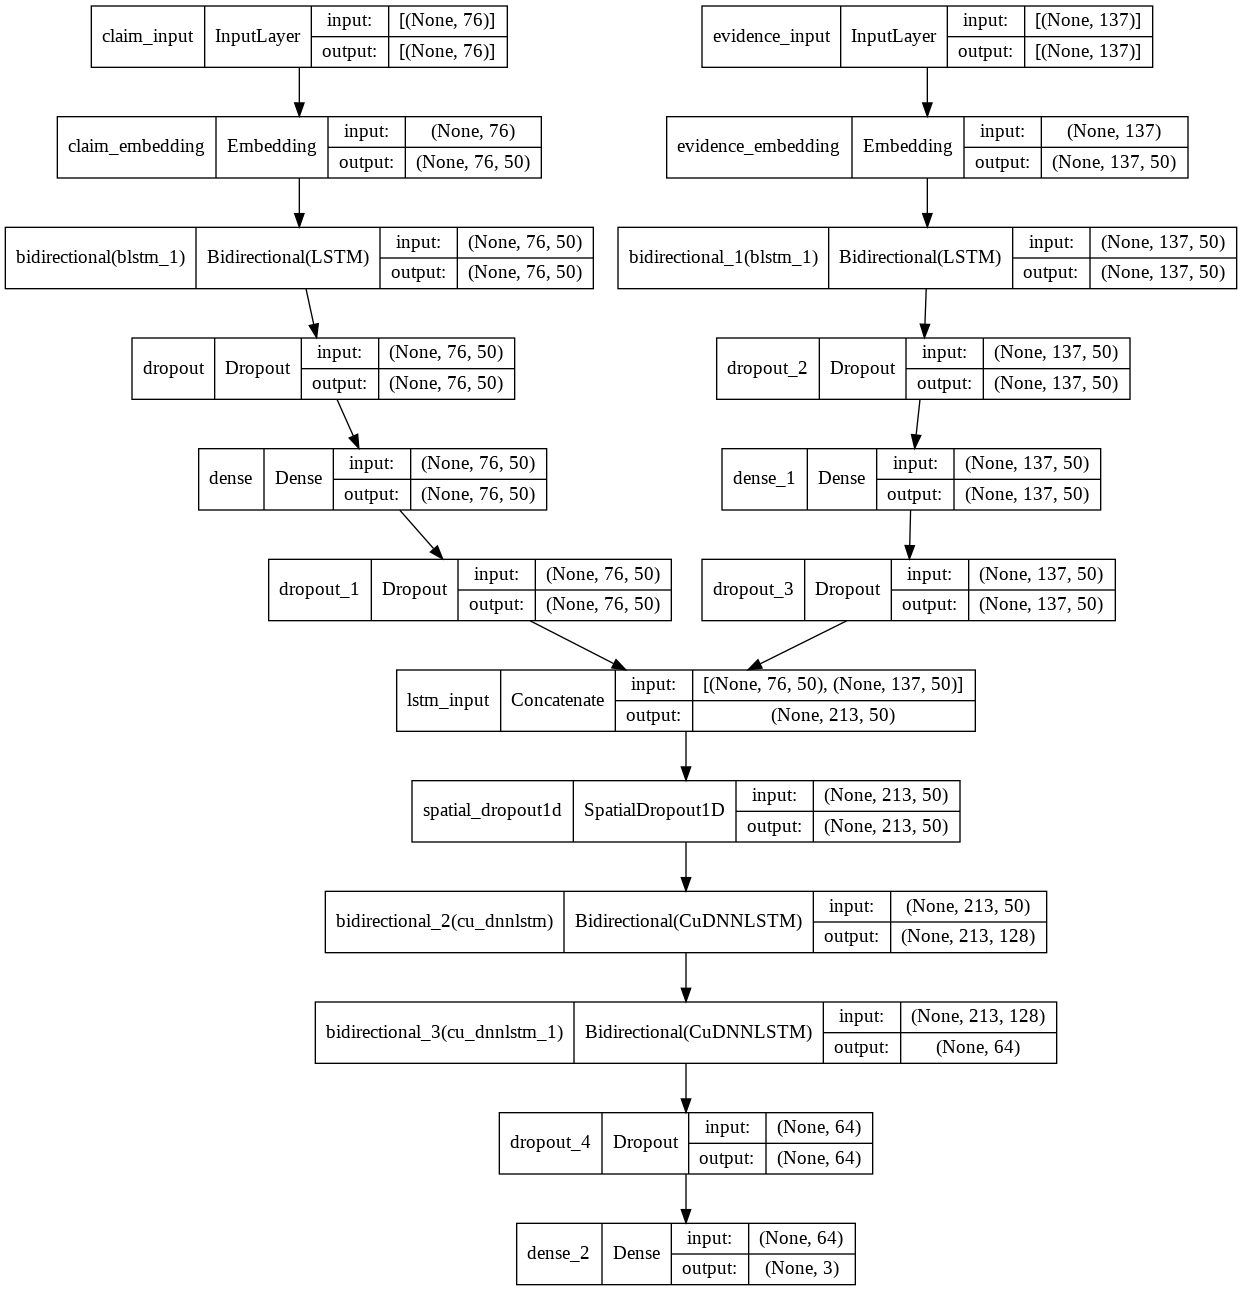

In [15]:
tf.keras.utils.plot_model(model_main,show_shapes=True)

In [16]:
y_train = df_train.Label
tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(y_train)
y_train = tokenizer_y.texts_to_sequences(y_train)
y_train = tf.keras.utils.to_categorical( y_train, num_classes=None, dtype='int')

In [17]:
y_val = df_val.Label
y_val = tokenizer_y.texts_to_sequences(y_val)
y_val = tf.keras.utils.to_categorical( y_val, num_classes=None, dtype='int')

In [18]:
y_test = df_test.Label
y_test = tokenizer_y.texts_to_sequences(y_test)
y_test = tf.keras.utils.to_categorical( y_test, num_classes=None, dtype='int')

In [19]:
history = model_main.fit(data_train, y_train,validation_data=(data_val,y_val),epochs=10, batch_size=1280, verbose=1)

Epoch 1/10
96/96 [==============================] - 59s 490ms/step - loss: 0.4121 - acc: 0.7321 - val_loss: 0.5478 - val_acc: 0.5040
Epoch 2/10
96/96 [==============================] - 44s 461ms/step - loss: 0.3378 - acc: 0.7746 - val_loss: 0.4310 - val_acc: 0.6863
Epoch 3/10
96/96 [==============================] - 44s 462ms/step - loss: 0.2768 - acc: 0.8307 - val_loss: 0.4256 - val_acc: 0.6911
Epoch 4/10
96/96 [==============================] - 44s 462ms/step - loss: 0.2506 - acc: 0.8460 - val_loss: 0.3949 - val_acc: 0.7100
Epoch 5/10
96/96 [==============================] - 44s 460ms/step - loss: 0.2320 - acc: 0.8577 - val_loss: 0.3742 - val_acc: 0.7242
Epoch 6/10
96/96 [==============================] - 44s 462ms/step - loss: 0.2176 - acc: 0.8669 - val_loss: 0.3560 - val_acc: 0.7403
Epoch 7/10
96/96 [==============================] - 44s 460ms/step - loss: 0.2070 - acc: 0.8726 - val_loss: 0.4073 - val_acc: 0.7284
Epoch 8/10
96/96 [==============================] - 44s 461ms/step - 

In [26]:
preds = model_main.predict(data_test, batch_size=1280, verbose=1)
b = pd.DataFrame(y_test)
b.head(50)

6/6 [==============================] - 1s 180ms/step


,0,1,2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0
6,0,1,0
7,0,1,0
8,0,1,0
9,0,0,1


In [28]:
a = pd.DataFrame((np.around(preds, decimals = 0, out = None)), dtype='int')
a.head(20)

,0,1,2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0
6,0,1,0
7,0,1,0
8,0,1,0
9,0,0,1


In [42]:
count = 0
for i in range (0,a.shape[0]):
  if not(a[0][i] == b[0][i]) or not(a[1][i] == b[1][i]) or not(a[2][i] == b[2][i]):
    count =+1
print(count/a.shape[0]*100)

0.013910140492418973


In [43]:
a.shape[0]

7189

In [37]:
a[0][0]

KeyError: ignored

In [36]:
a.head(20)

,0,1,2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0
6,0,1,0
7,0,1,0
8,0,1,0
9,0,0,1
